# Vehicle Detection and Tracking

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [31]:
import glob 
import cv2
import numpy as np
import skimage
import matplotlib.image as mpimg
from skimage import data, color, exposure
from sklearn.model_selection import train_test_split
from skimage.feature import hog
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten,Lambda
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
import matplotlib.pylab as plt
import scipy
import imutils

%matplotlib inline
%load_ext autoreload
%matplotlib inline



LOAD_WEIGHTS = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:

cars = glob.glob("./data/vehicles/*/*.png")
non_cars = glob.glob("./data/non-vehicles/*/*.png")

# make ground truth
Y = np.concatenate([np.ones(len(cars)), np.zeros(len(non_cars))-1])
# read X
X = []
for name in cars:    
    X.append(skimage.io.imread(name))
for name in non_cars:    
    X.append(skimage.io.imread(name))
X = np.array(X)

In [33]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.10, random_state=42)


X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')
input_shape =  (3,64,64)

X_train shape: (15984, 64, 64, 3)
15984 train samples
1776 test samples


In [34]:
#load testing picture

TEST_IMG_RBG = mpimg.imread(cars[4])
TEST_IMG_G = cv2.cvtColor(TEST_IMG_RBG, cv2.COLOR_RGB2GRAY)

TEST_FULL_IMG = mpimg.imread("./test_images/test1.jpg")

## 1. Histogram of Oriented Gradients (HOG)
#### 1.1.1 Explain how (and identify where in your code) you extracted HOG features from the training images. 

In [35]:
def process_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features

#### 1.1.2 Explain how you settled on your final choice of HOG parameters.

In [36]:
orient = 9
pix_per_cell = 4
cell_per_block = 2

In [37]:
# Call our function with vis=True to see an image output
features, hog_image = process_hog_features(TEST_IMG_G, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=False)

In [38]:
# Call our function with vis=True to see an image output
features = process_hog_features(TEST_IMG_G, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)

In [39]:
features.shape

(15, 15, 2, 2, 9)

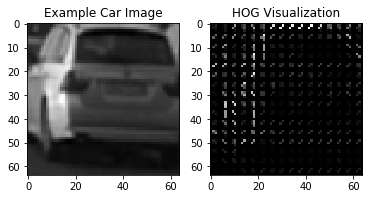

In [40]:
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(TEST_IMG_G, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [41]:
hog_image.shape

(64, 64)

#### 1.2 Describe how (and identify where in your code) you trained a classifier using your selected HOG features (and color features if you used them).

#### 1.2.1 Binary Classifier
I use keras to build the classifier for classify it is a car. 

In [42]:
# define conv layers
def conv_layers(input_shape, weights_file=None):
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape, output_shape=input_shape))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv1',input_shape=input_shape, border_mode="same"))
    model.add(Convolution2D(10, 3, 3, activation='relu', name='conv2',border_mode="same"))
    print("model.conv2", model.output_shape)
    model.add(MaxPooling2D(pool_size=(8,8)))
    model.add(Dropout(0.25))
    model.add(Convolution2D(128,8,8,activation="relu",name="dense1")) 
    model.add(Dropout(0.5))
    model.add(Convolution2D(1,1,1,name="dense2", activation="tanh")) 
    if weights_file:
        model.load_weights(weights_file)        
    return model

In [43]:
# train model
model = conv_layers((64,64,3))
print("model.output_shape()", model.output_shape)
model.add(Flatten())
model.compile(loss='mse',optimizer='adadelta',metrics=['accuracy'])

if LOAD_WEIGHTS:
    model.load_weights("weights.h5")     
    print("Loaded model")
else:
    model.fit(X_train, Y_train, batch_size=128, nb_epoch=20, verbose=1, validation_data=(X_test, Y_test))
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    model.save_weights("weights.h5")

model.conv2 (None, 64, 64, 10)
model.output_shape() (None, 1, 1, 1)
Loaded model


#### Heat Map generator 
I use the conv layers trained by keras to use as a fiter to get the heat map of car. 

In [44]:
TEST_FULL_IMG.shape

(720, 1280, 3)

In [111]:
heatMapModel = conv_layers(input_shape=(None,None,3), weights_file="weights.h5")

ratios = np.array([[1,1],[1,2]])
pixels = np.array([64,128])

class Roi:
    def __init__(self, x1,y1, x2, y2,ratio,pixel, resizedImg):
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
        self.ratio = ratio
        self.pixel = pixel
        self.resizedImg = resizedImg
    


def localize(img_rgb, videoMode=False):
    cpImg = np.copy(img_rgb)
    heatmap = heatMapModel.predict(img_rgb.reshape(1,img_rgb.shape[0],img_rgb.shape[1],img_rgb.shape[2]))

#     print("heatmap.shape", heatmap.shape)
    if not videoMode:
        plt.imshow(heatmap[0,:,:,0])
        plt.title("Heatmap")
        plt.show()
        plt.imshow(heatmap[0,:,:,0]>0.8, cmap="gray")
        plt.title("Car Area")
        plt.show()

#     print("heatmap.shape",heatmap.shape)
    xx, yy = np.meshgrid(np.arange(heatmap.shape[2]),np.arange(heatmap.shape[1]))
    x = (xx[heatmap[0,:,:,0]>0.8])
    y = (yy[heatmap[0,:,:,0]>0.8])

#     print("len(x)",len(x))

    yRatio = 720/83
    xRatio = 1280/153
    
    if not videoMode:
        fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
        out = cv2.VideoWriter('./output_1.avi', fourcc, 20.0, (TEST_FULL_IMG.shape[1], TEST_FULL_IMG.shape[0]))

#   create roi
    rois = []
    resizedImgs = []
    for i,j in zip(x,y):
        for pixel in pixels:
            for ratio in ratios:
                xOffset = int((ratio[1]*pixel)/2)
                yOffset = int((ratio[0]*pixel)/2)


                y1 = int(j * yRatio)
                x1 = int(i * xRatio)
                y2 = y1 + yOffset
                x2 = x1 + xOffset
                y1 =y1 - yOffset
                x1 =x1 - xOffset


                if y1 > 720 or y2 > 720 or x1 >1280 or x2 > 1280:
#                     print("i",i,"j",j)
#                     print("x1",x1,"y1",y1,"x2",x2,"y2",y2, "ratio",ratio,"pixel",pixel)
                    y1 = y1 if y1<720 else 719
                    y2 = y2 if y2<720 else 719
                    x1 = x1 if x1<1280 else 1279
                    x2 = x2 if x2<1280 else 1279
#                     print("x1",x1,"y1",y1,"x2",x2,"y2",y2, "ratio",ratio,"pixel",pixel)
#                     continue

                if y1 <0 or y2 <0 or x1 <0 or x2<0:
                    y1 = y1 if y1>0 else 0
                    y2 = y2 if y2>0 else 0
                    x1 = x1 if x1>0 else 0
                    x2 = x2 if x2>0 else 0

                seletedImg = img_rgb[y1:y2,x1:x2,:]

                cv2.rectangle(cpImg, (x1,y1), (x2,y2), (0,0,255), 1)


#                 print("seletedImg.shape",seletedImg.shape)
                resizedImg = scipy.misc.imresize(seletedImg, (64, 64,3), interp='nearest')
                roi = Roi(x1,y1,x2,y2,ratio,pixel,resizedImg)
                rois.append(roi)
                resizedImgs.append(resizedImg)


                clone = img_rgb.copy()
                cv2.rectangle(clone, (x1,y1), (x2,y2), (0, 255, 0), 3)
#                 plt.figure()
#                 plt.imshow(clone)

                if not videoMode:
                    out.write(cv2.resize(clone,  (TEST_FULL_IMG.shape[1], TEST_FULL_IMG.shape[0])) )




    if not videoMode:
        out.release()
    
    resizedImgs= np.array(resizedImgs)
    classes = model.predict(resizedImgs)
    return cpImg, heatmap, np.array(rois),resizedImgs, classes.flatten()


model.conv2 (None, None, None, 10)


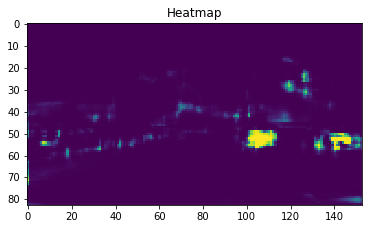

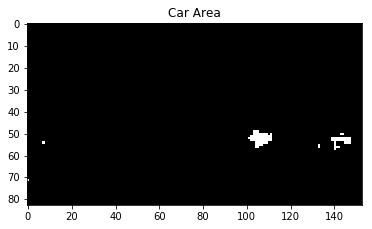

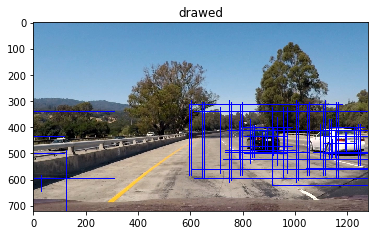

In [112]:
cp = np.copy(TEST_FULL_IMG)
annotated, heatMap, rois, resizedImgs,classes = localize(cp)

plt.title("drawed")    
plt.imshow(annotated, cmap="gray")
plt.show()

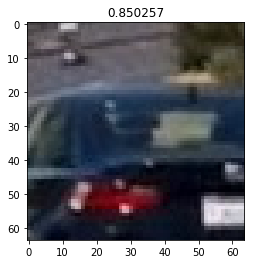

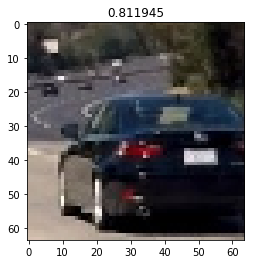

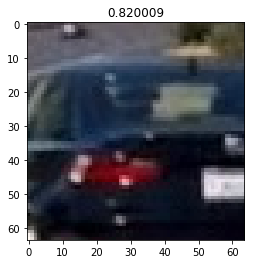

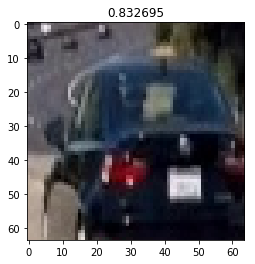

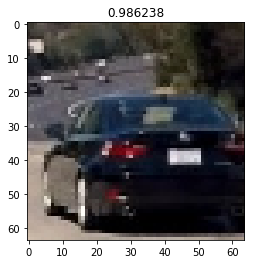

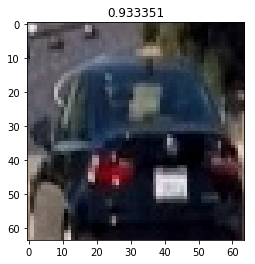

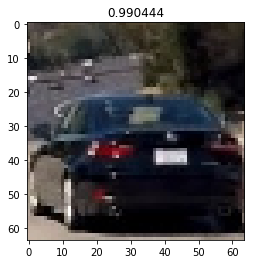

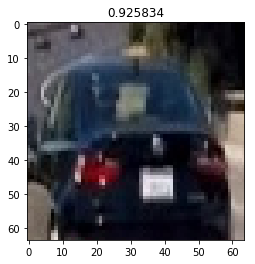

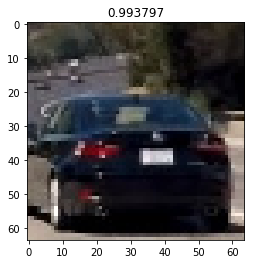

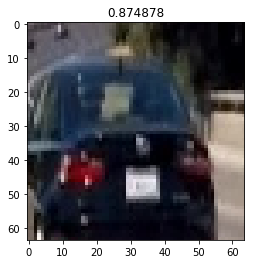

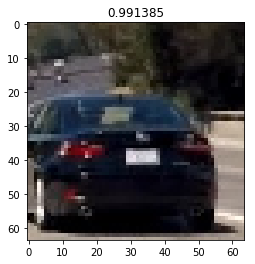

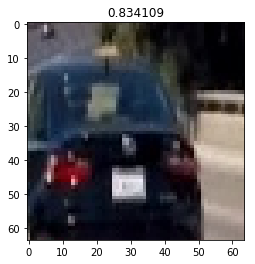

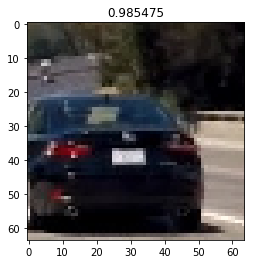

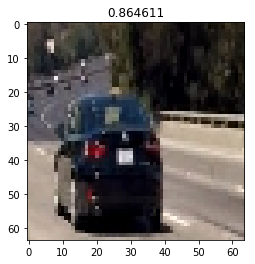

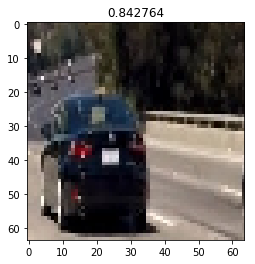

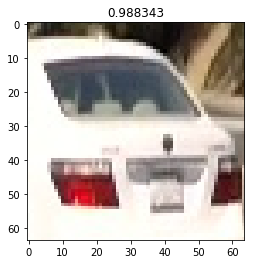

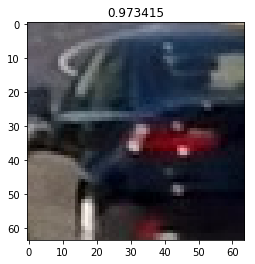

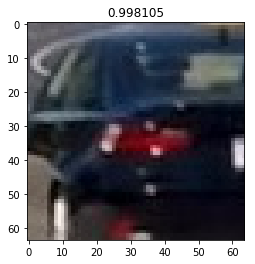

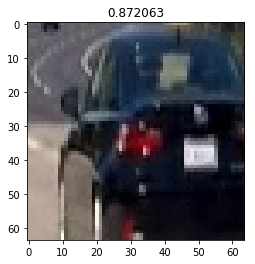

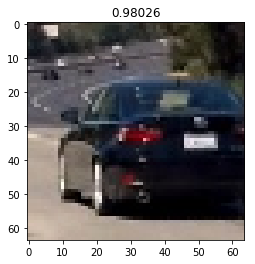

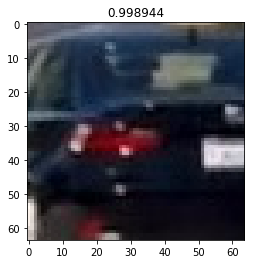

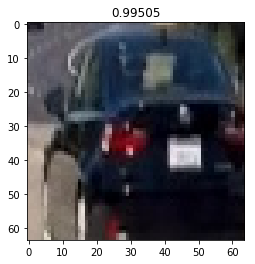

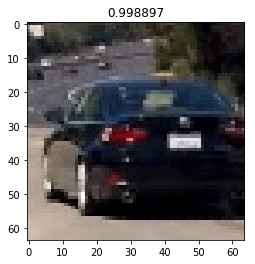

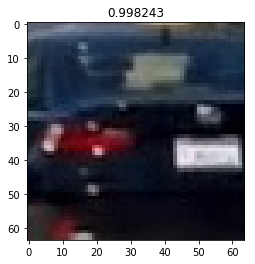

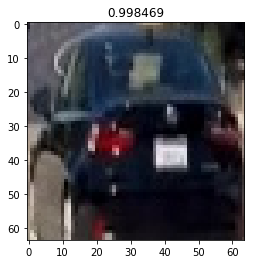

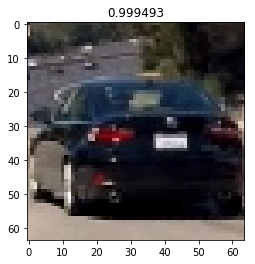

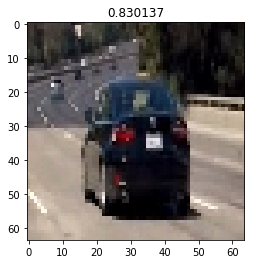

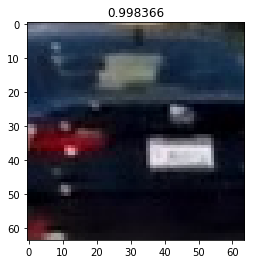

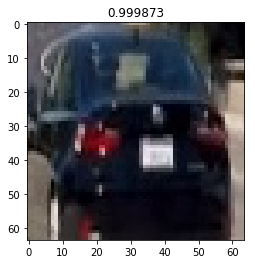

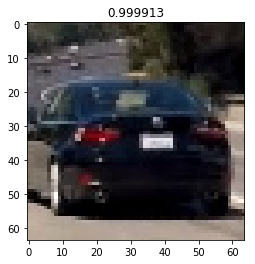

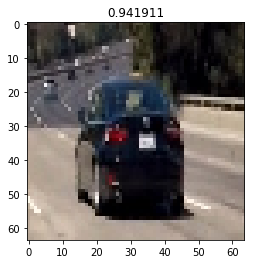

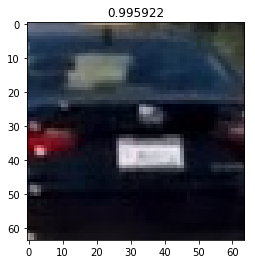

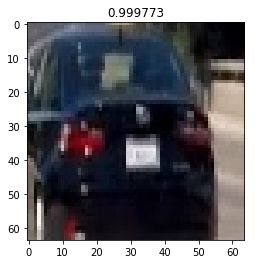

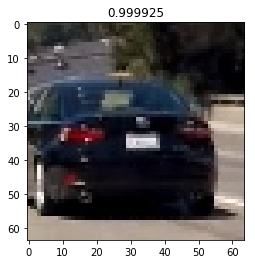

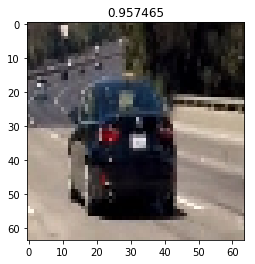

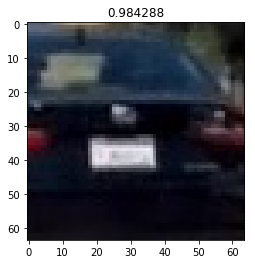

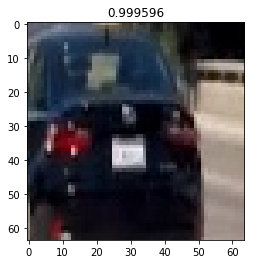

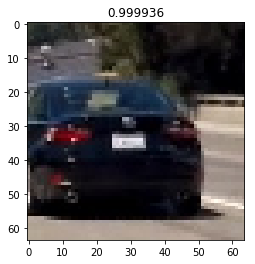

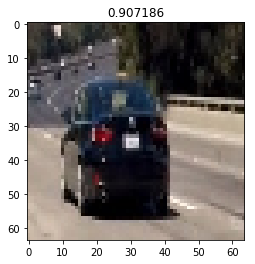

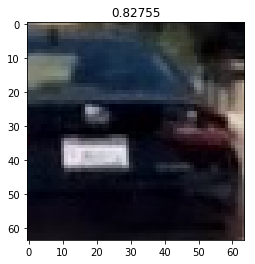

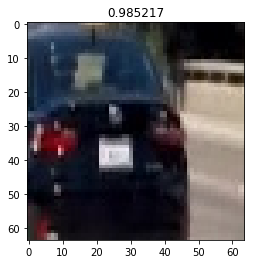

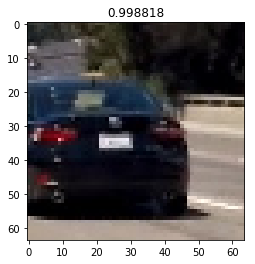

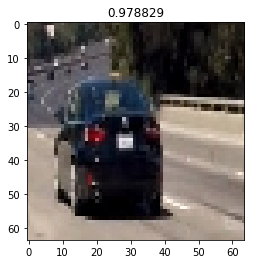

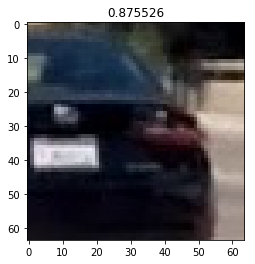

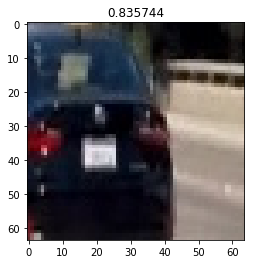

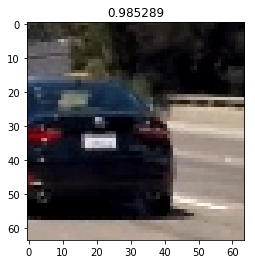

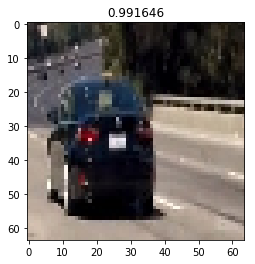

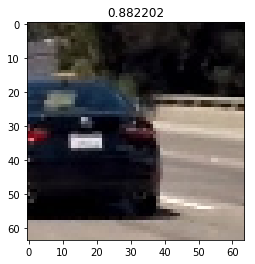

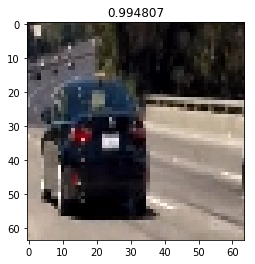

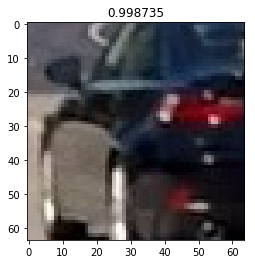

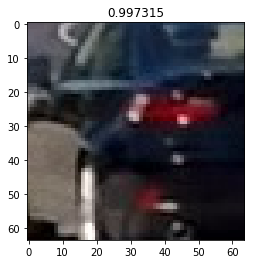

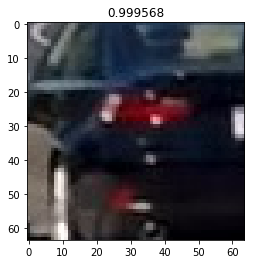

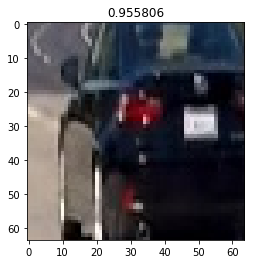

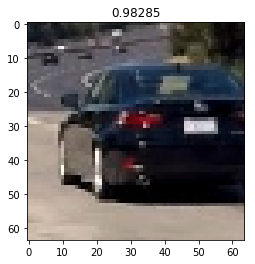

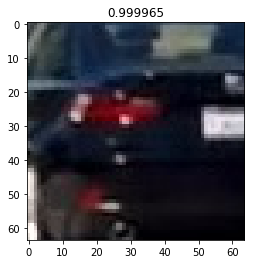

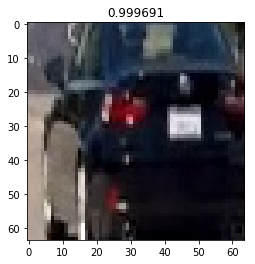

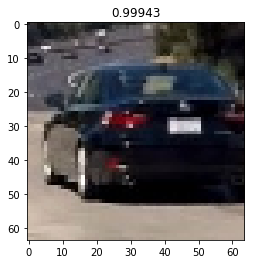

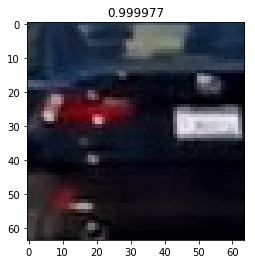

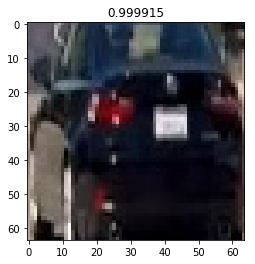

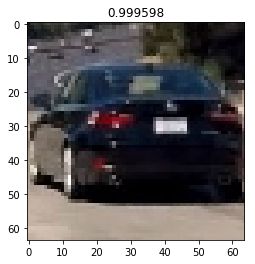

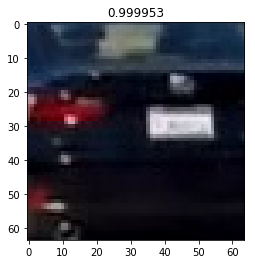

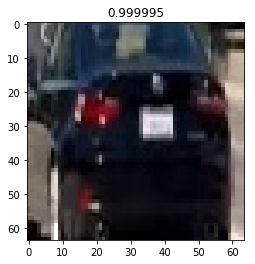

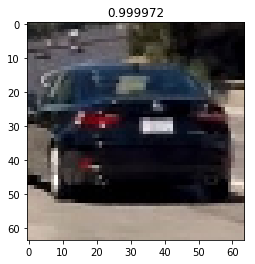

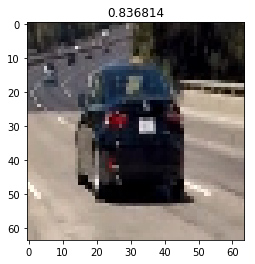

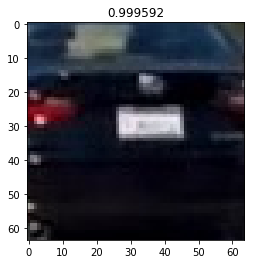

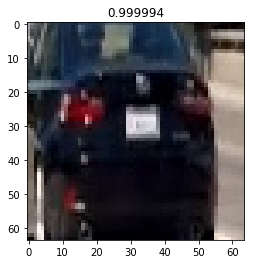

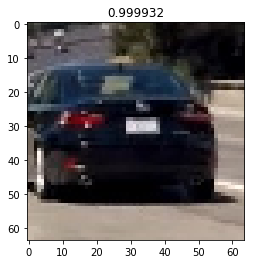

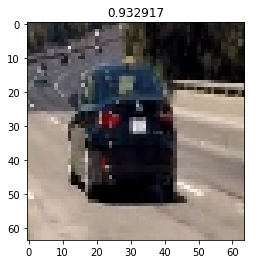

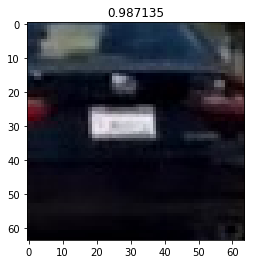

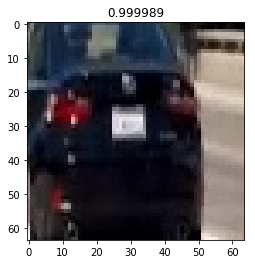

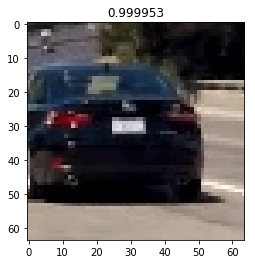

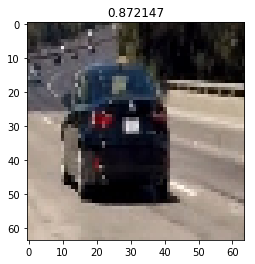

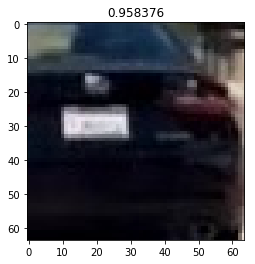

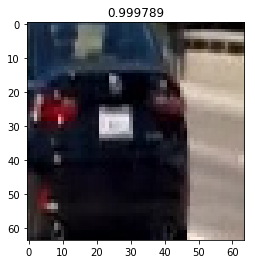

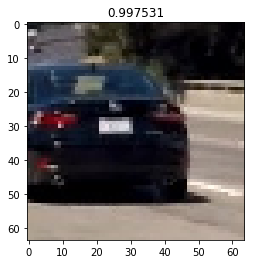

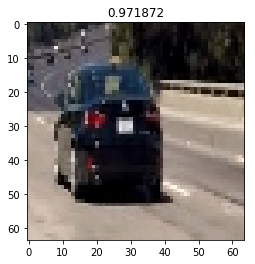

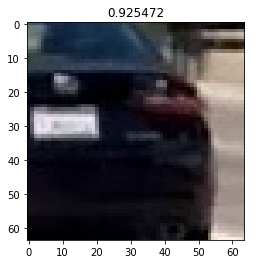

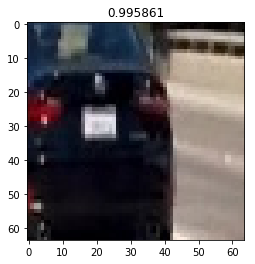

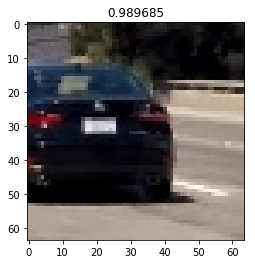

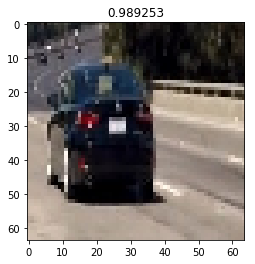

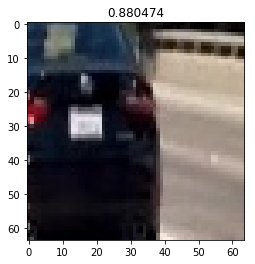

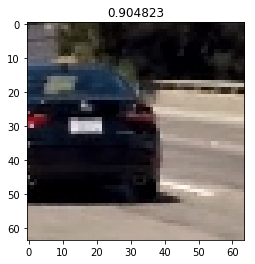

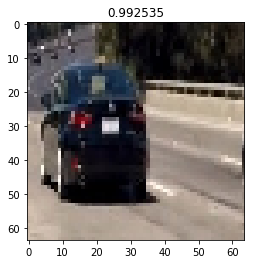

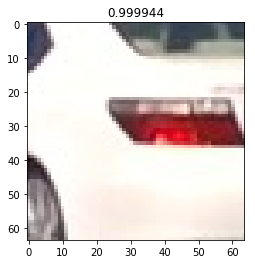

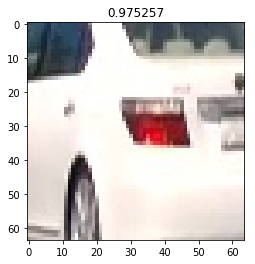

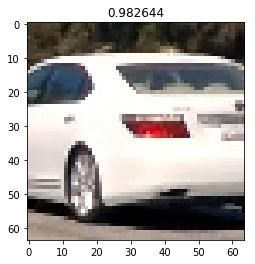

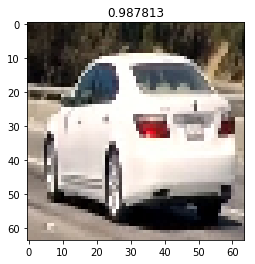

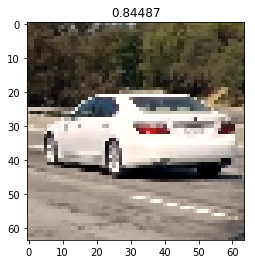

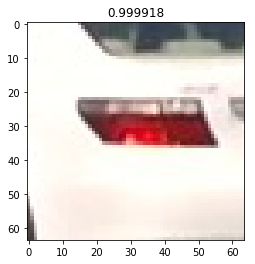

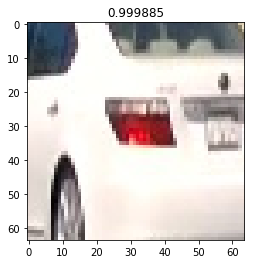

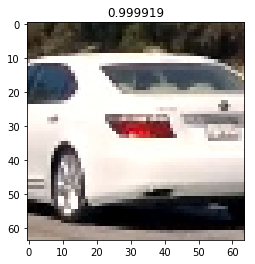

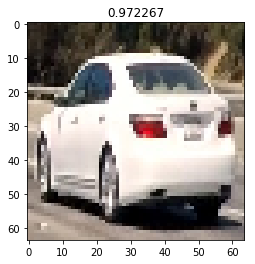

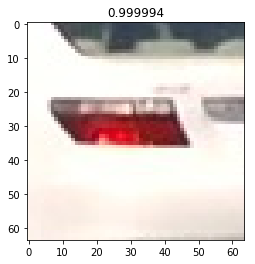

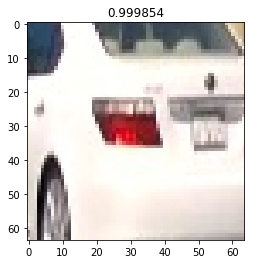

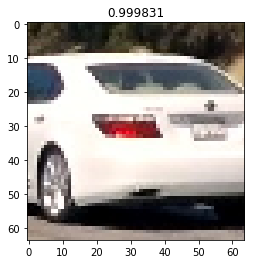

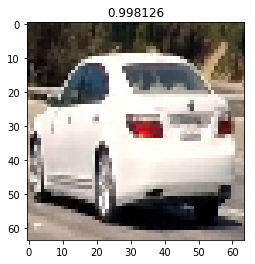

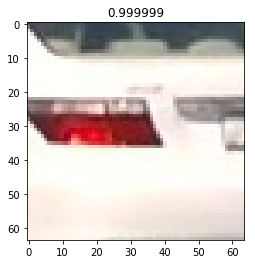

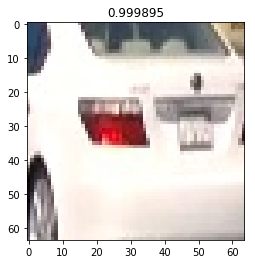

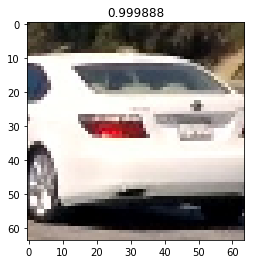

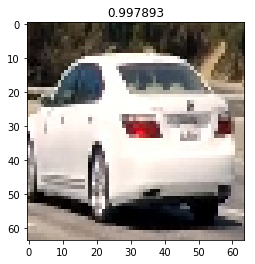

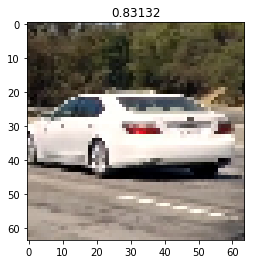

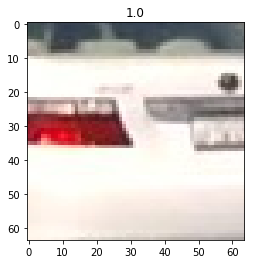

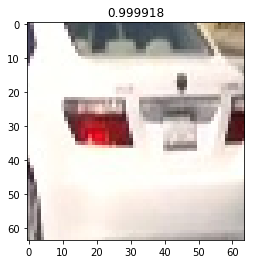

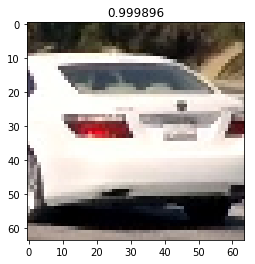

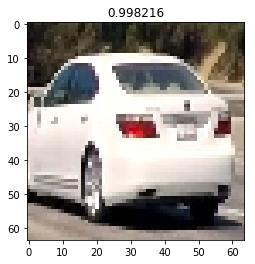

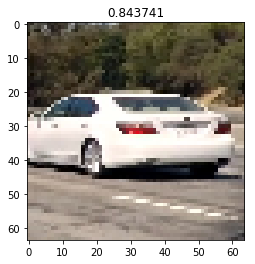

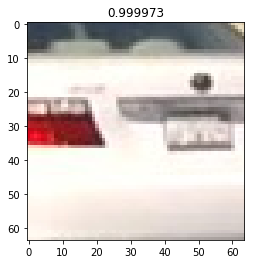

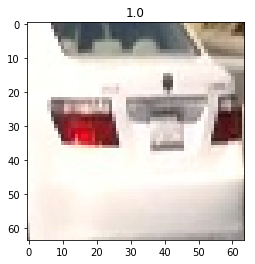

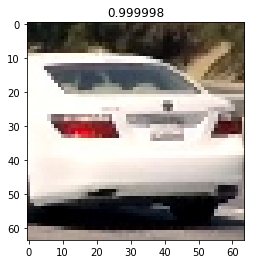

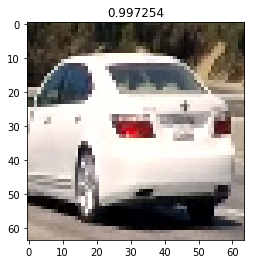

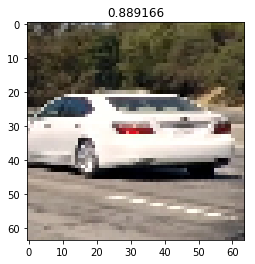

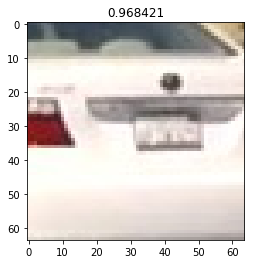

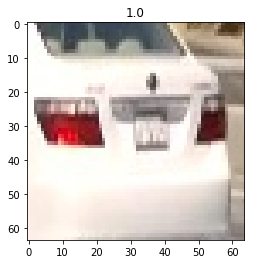

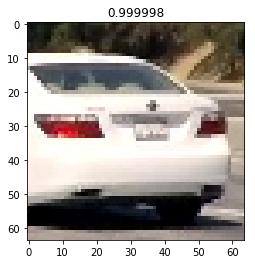

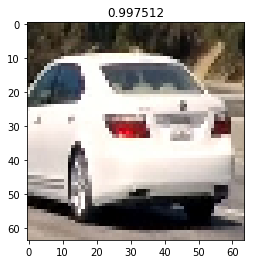

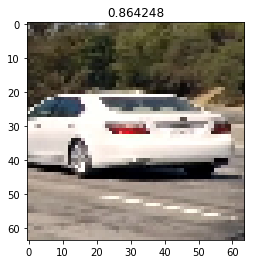

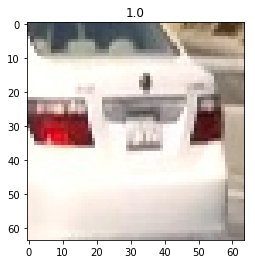

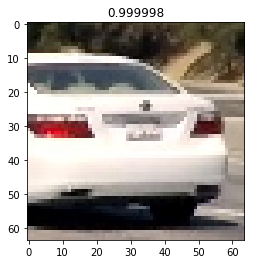

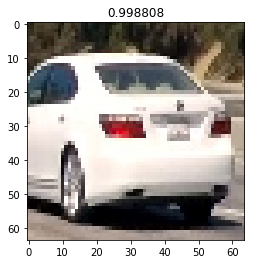

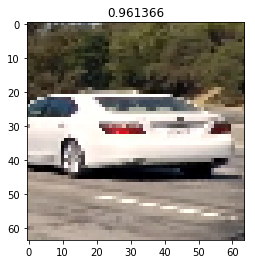

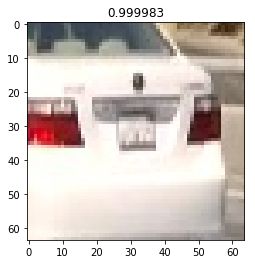

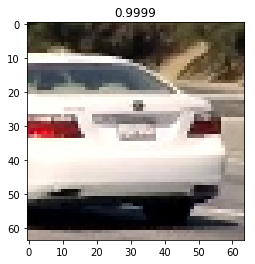

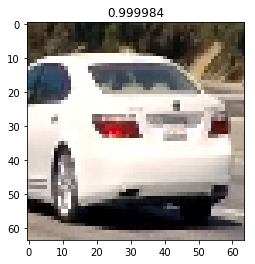

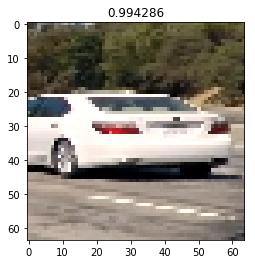

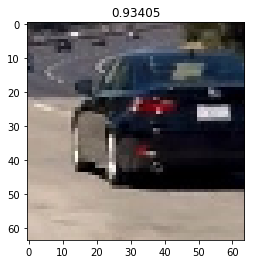

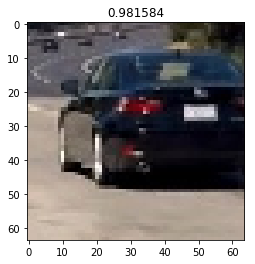

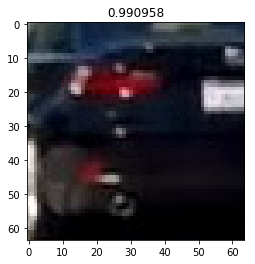

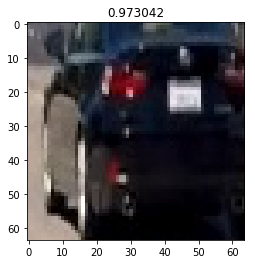

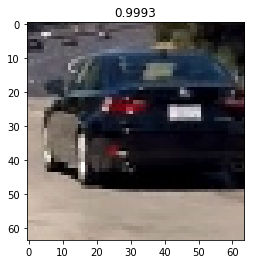

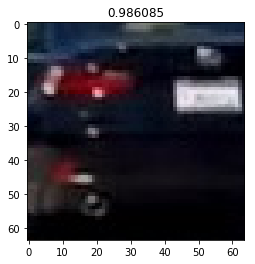

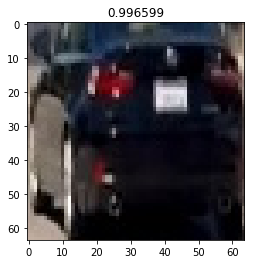

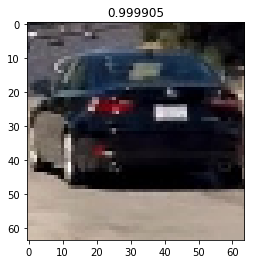

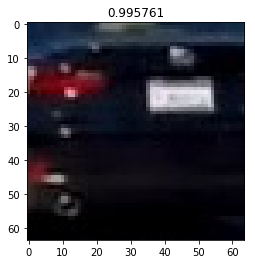

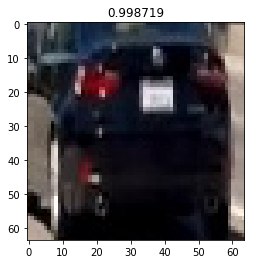

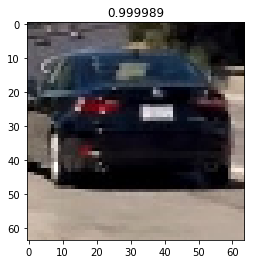

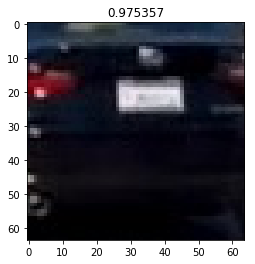

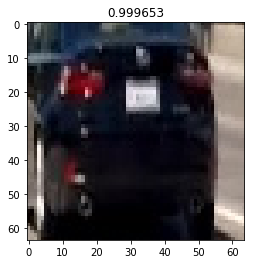

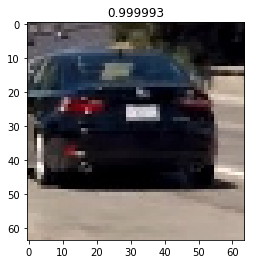

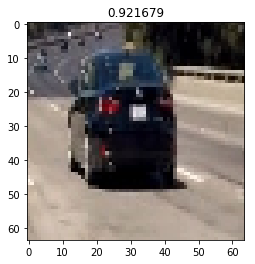

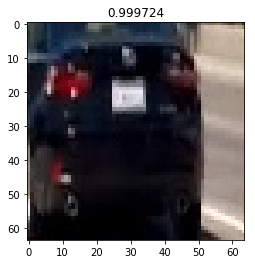

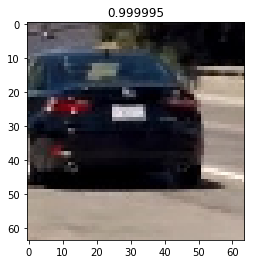

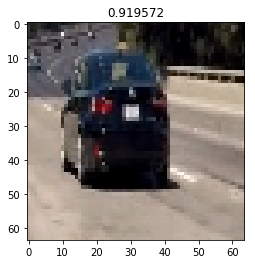

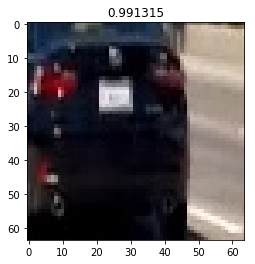

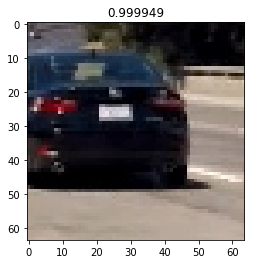

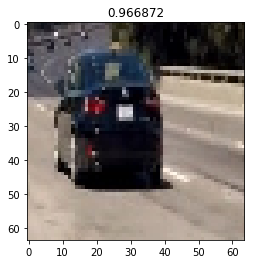

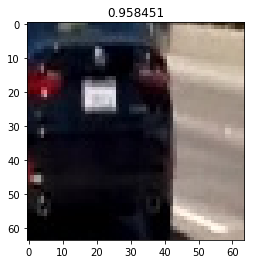

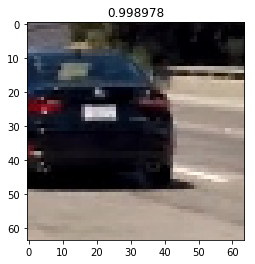

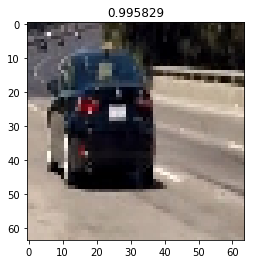

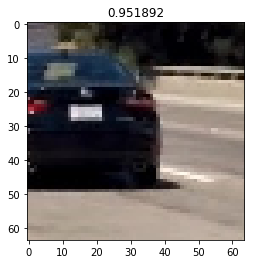

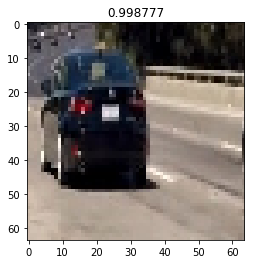

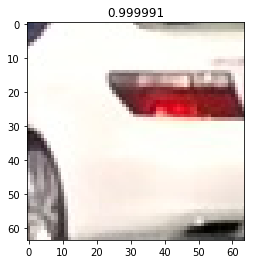

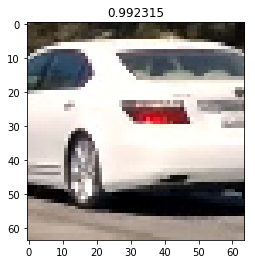

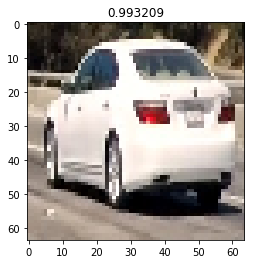

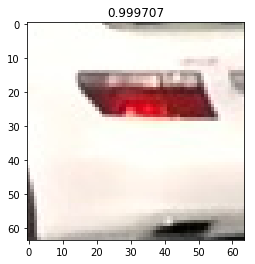

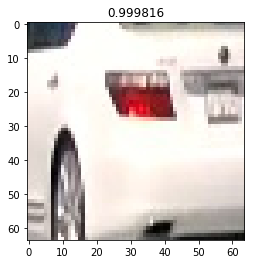

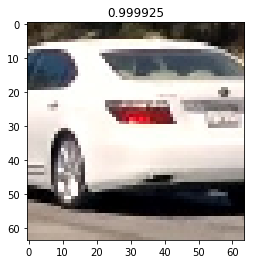

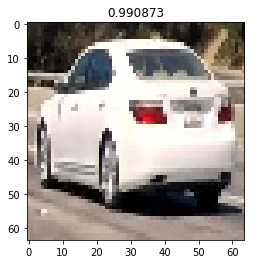

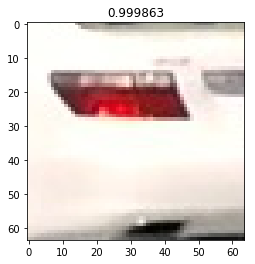

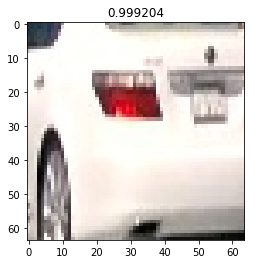

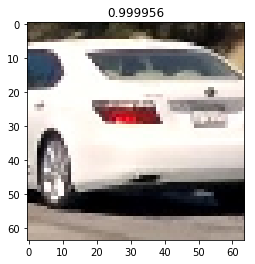

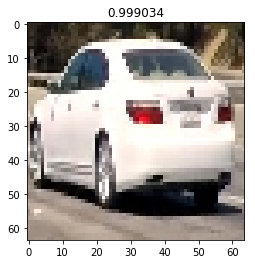

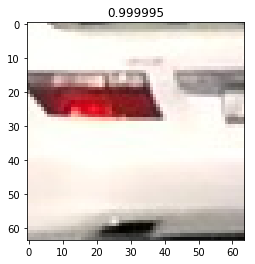

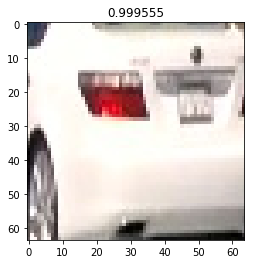

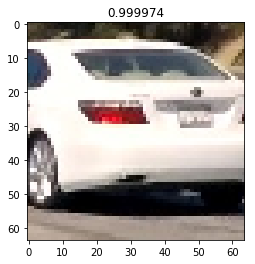

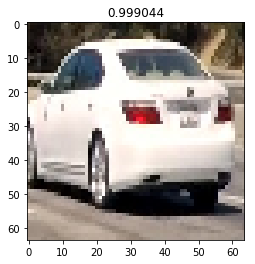

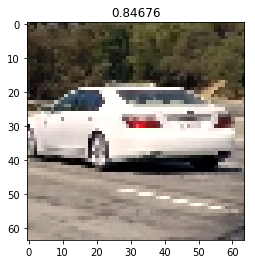

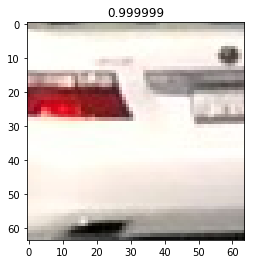

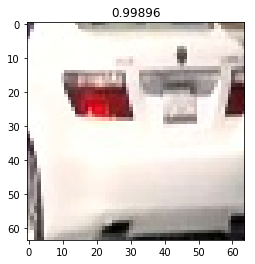

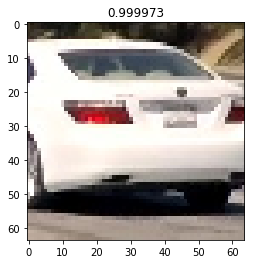

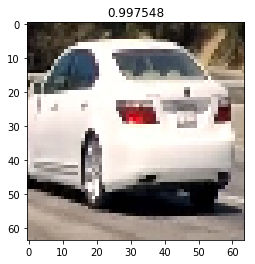

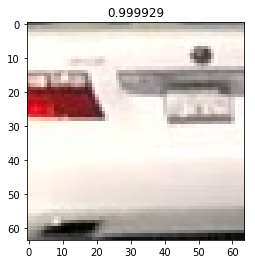

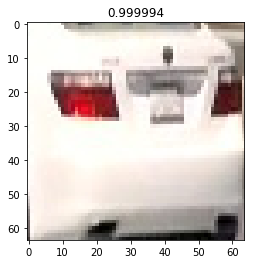

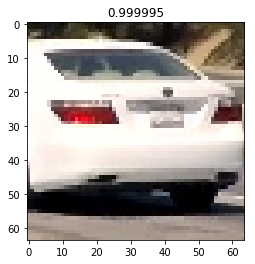

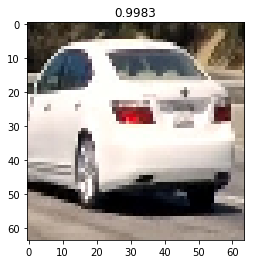

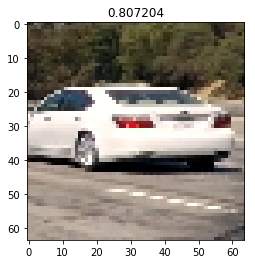

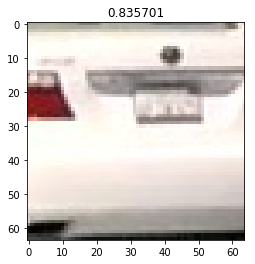

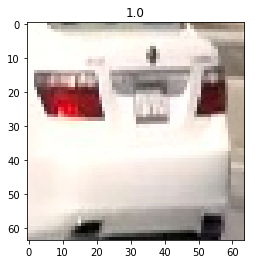

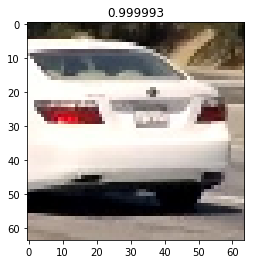

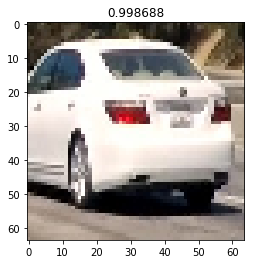

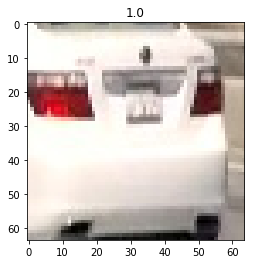

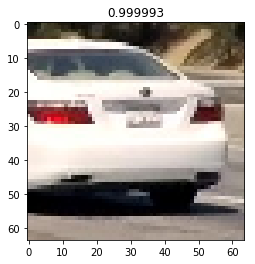

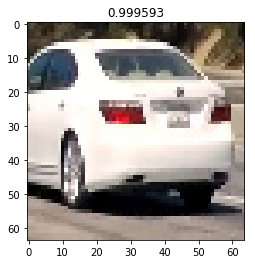

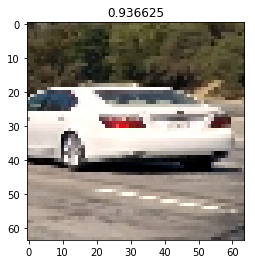

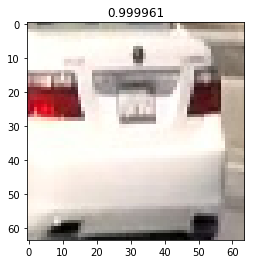

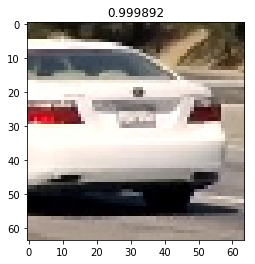

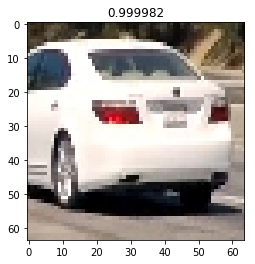

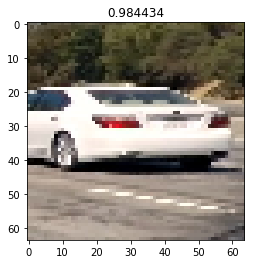

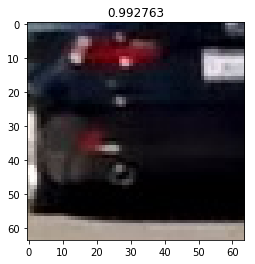

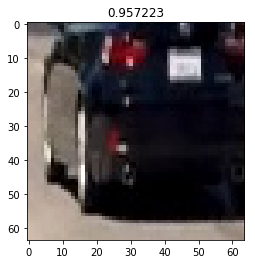

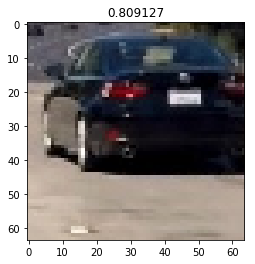

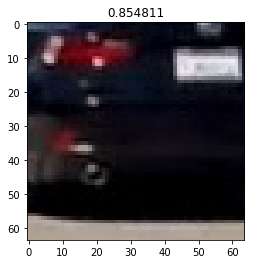

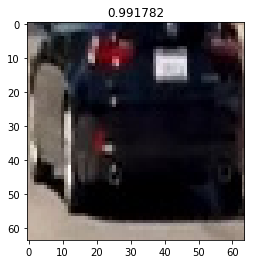

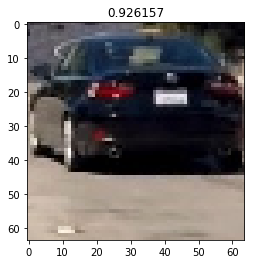

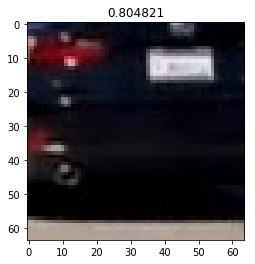

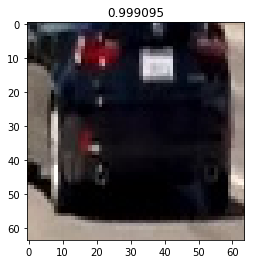

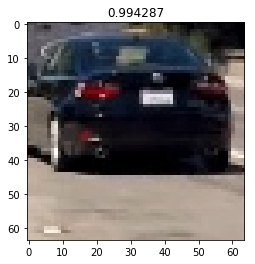

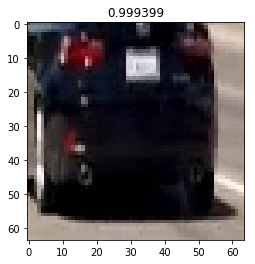

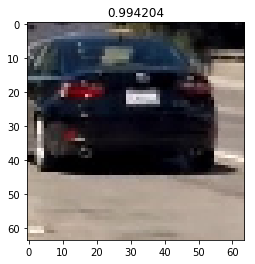

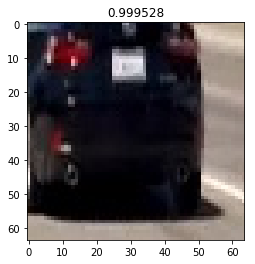

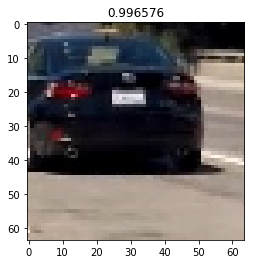

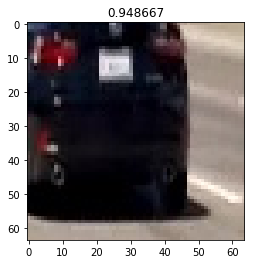

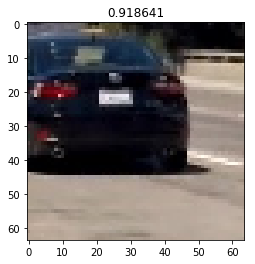

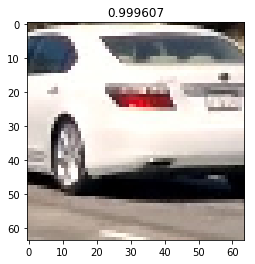

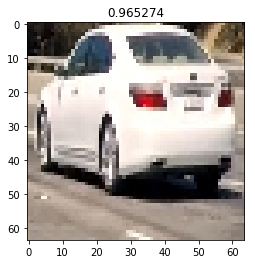

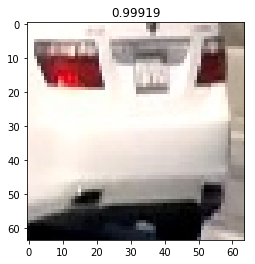

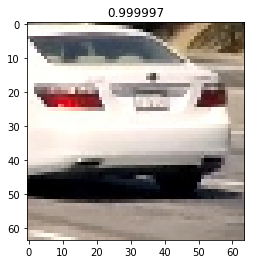

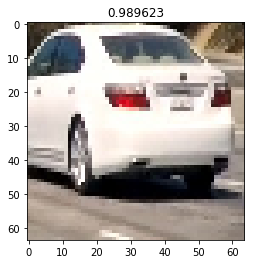

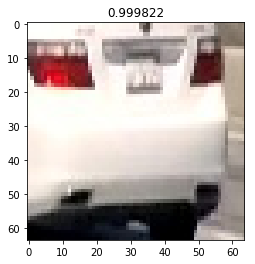

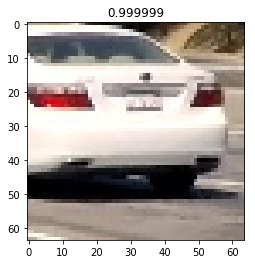

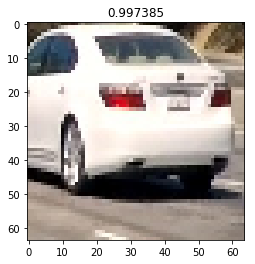

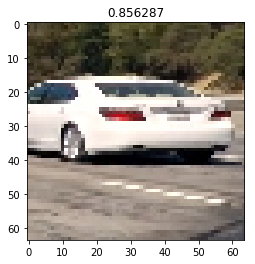

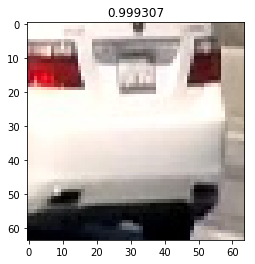

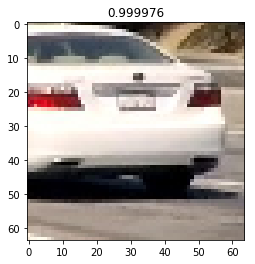

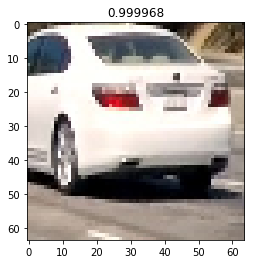

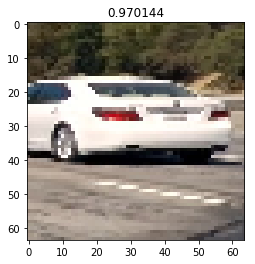

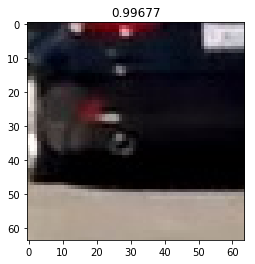

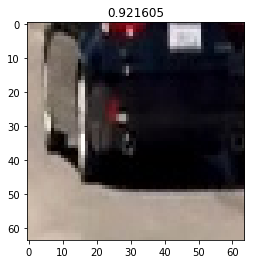

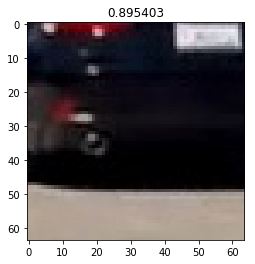

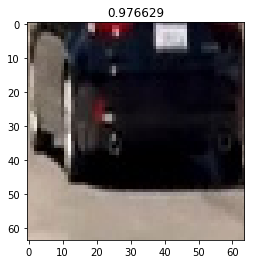

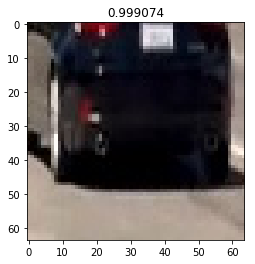

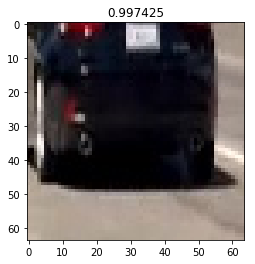

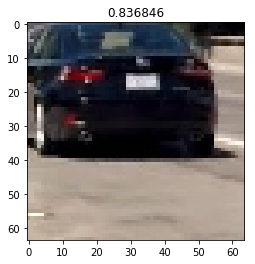

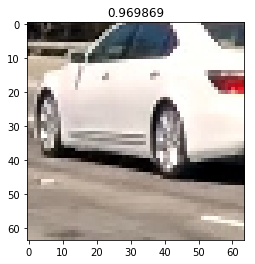

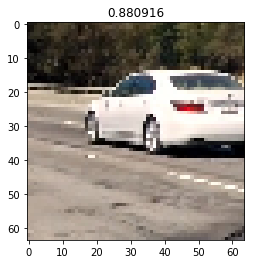

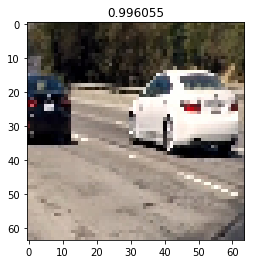

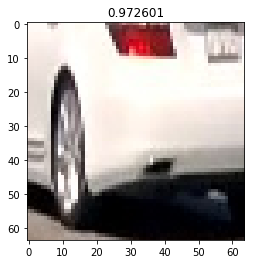

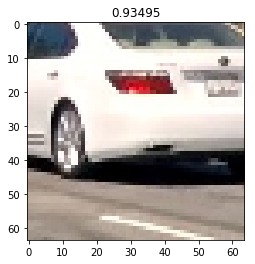

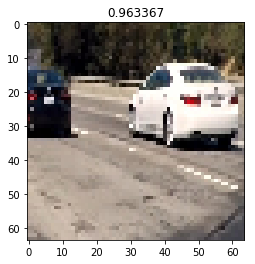

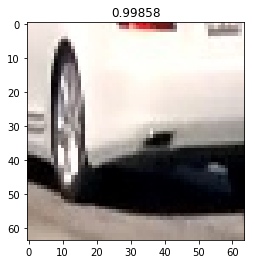

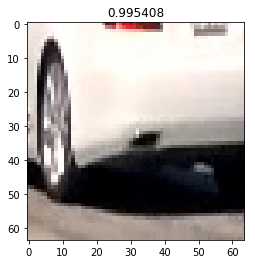

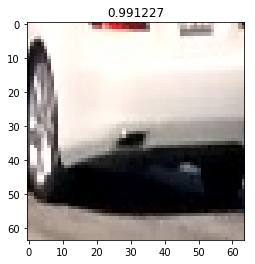

In [113]:
for prob, img in zip(classes,resizedImgs):
    if prob >0.8:
        plt.figure()
        plt.title(prob)
        plt.imshow(img)

In [114]:
heatMap_ = np.reshape(heatMap[0],(heatMap.shape[1],heatMap.shape[2]))

In [115]:

def non_max_suppression_fast(boxes=[], overlapThresh=0.7):

    # if there are no boxes, return an empty list

    if len(boxes) == 0:
        return []

    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions

    if boxes.dtype.kind == 'i':
        boxes = boxes.astype('float')

    # initialize the list of picked indexes....

    pick = []

    # grab the coordinates of the bounding boxes

    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    # keep looping while some indexes still remain in the indexes
    # list

    while len(idxs) > 0:

        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes

        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box

        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap

        overlap = w * h / area[idxs[:last]]

        # delete all indexes from the index list that have

        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap
                         > overlapThresh)[0])))

    # return only the bounding boxes that were picked using the
    # integer data type

    return pick



In [116]:
thresd_idx = classes>0.95
thres_classes = classes[thresd_idx]
thres_rois = rois[thresd_idx]
print("len boxes", len(boxes))
boxes = []
for roi in thres_rois:
    boxes.append([roi.x1, roi.y1, roi.x2, roi.y2] )
boxes = np.array(boxes)

idx = non_max_suppression_fast(boxes, 0.55)
print("len boxes new", len(idx))


len boxes 168
len boxes new 2


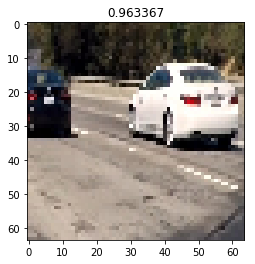

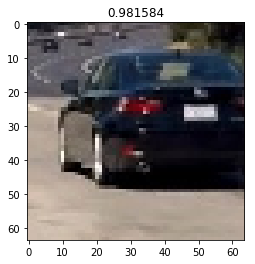

In [117]:
selected_class = thres_classes[idx]
selected_roi = thres_rois[idx]
for prob, roi in zip(selected_class,selected_roi):
    plt.figure()
    plt.title(prob)
    plt.imshow(roi.resizedImg)

## 2. Sliding Window Search
#### 2.1.1 Describe how (and identify where in your code) you implemented a sliding window search. 

In [118]:
def pipeLine(img):
    cp = np.copy(img)
    annotated, heatMap, rois, resizedImgs,classes = localize(cp, True)
    thresd_idx = classes>0.95
    thres_classes = classes[thresd_idx]
    thres_rois = rois[thresd_idx]
    boxes = []
    for roi in thres_rois:
        boxes.append([roi.x1, roi.y1, roi.x2, roi.y2] )
    boxes = np.array(boxes)
    idx = non_max_suppression_fast(boxes, 0.55)
    selected_class = thres_classes[idx]
    selected_roi = thres_rois[idx]
    for prob, roi  in zip(selected_class,selected_roi):
        cv2.rectangle(cp, (roi.x1,roi.y1), (roi.x2,roi.y2), (0, 255, 0), 3)
    return cp

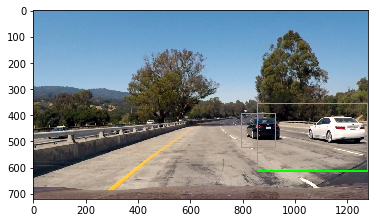

In [119]:
resImg = pipeLine(TEST_FULL_IMG)
plt.figure()
plt.imshow(resImg)

####  2.1.2 How did you decide what scales to search and how much to overlap windows?

#### 2.2.1 Show some examples of test images to demonstrate how your pipeline is working. 

#### 2.2.1 How did you optimize the performance of your classifier?

## 3. Video Implementation
#### 3.1 Provide a link to your final video output. Your pipeline should perform reasonably well on the entire project video (somewhat wobbly or unstable bounding boxes are ok as long as you are identifying the vehicles most of the time with minimal false positives.)

In [120]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'test_video_out.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(pipeLine) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)


[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:28<00:00,  1.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 28.6 s, sys: 580 ms, total: 29.1 s
Wall time: 29.5 s


In [121]:
from IPython.core.display import HTML
HTML("""
    <video controls src="{0}" loop=1 autoplay width=100%/> 
    """.format('test_video_out.mp4')
)

#### 3.2 Describe how (and identify where in your code) you implemented some kind of filter for false positives and some method for combining overlapping bounding boxes.

## 3. Discussion
#### 3.1 Briefly discuss any problems / issues you faced in your implementation of this project. 

#### 3.2 Where will your pipeline likely fail?

#### 3.3 What could you do to make it more robust?